In [23]:
# -*- coding: utf-8 -*-
import os, sys
import glob
import json
sys.path.append("..")
sys.path.append("../..")
import dataset_utils.utils as utils
import dataset_utils.config as config
import pympi
import sklearn.metrics as metrics
from collections import defaultdict
import copy
import pickle

import utils
import smoothing_methods

In [24]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [25]:
test_ids = [("05_01", "A"), ("05_01", "C"), ("05_01", "D"), ("05_02", "A"), ("05_02", "C"), ("05_02", "D")]
base_path = config.DS_DIALOG
prediction_dir = os.path.join(base_path, "detection_result")
label_dir = os.path.join(base_path, "ant")
img_dir = os.path.join(base_path, "image")

In [26]:
def visualize(labels, predictions, frame_num, title, target=None, fig_path=None):
    x = [i for i in range(1, frame_num+1)]
    if target:
        x = x[target[0]:target[1]]
        labels = labels[target[0]:target[1]]
        predictions = predictions[target[0]:target[1]]
    fig, axes = plt.subplots(figsize=(40,5))
    fig.suptitle(title, fontsize=16)
    axes.plot(x, labels, linewidth=2, color="red")
    axes.plot(x, predictions, linewidth=0.3, color="#C3DEF1")
    plt.fill_between(x, predictions, 0, color="#C3DEF1")
    axes.set_ylim([0, 1.1])
    axes.set_ylabel("locked (1) or non-locked(0)")
    axes.set_xlabel("frame")
    if fig_path:
        plt.savefig(os.path.join(fig_path))

# raw

Parsing unknown version of ELAN spec... This could result in errors...
05_01_A -> 0.863523
Parsing unknown version of ELAN spec... This could result in errors...
05_01_C -> 0.936829
Parsing unknown version of ELAN spec... This could result in errors...
05_01_D -> 0.937051
Parsing unknown version of ELAN spec... This could result in errors...
05_02_A -> 0.916457
Parsing unknown version of ELAN spec... This could result in errors...
05_02_C -> 0.927384
Parsing unknown version of ELAN spec... This could result in errors...
05_02_D -> 0.958642
f1_score: 0.848269
auc_score: 0.923314


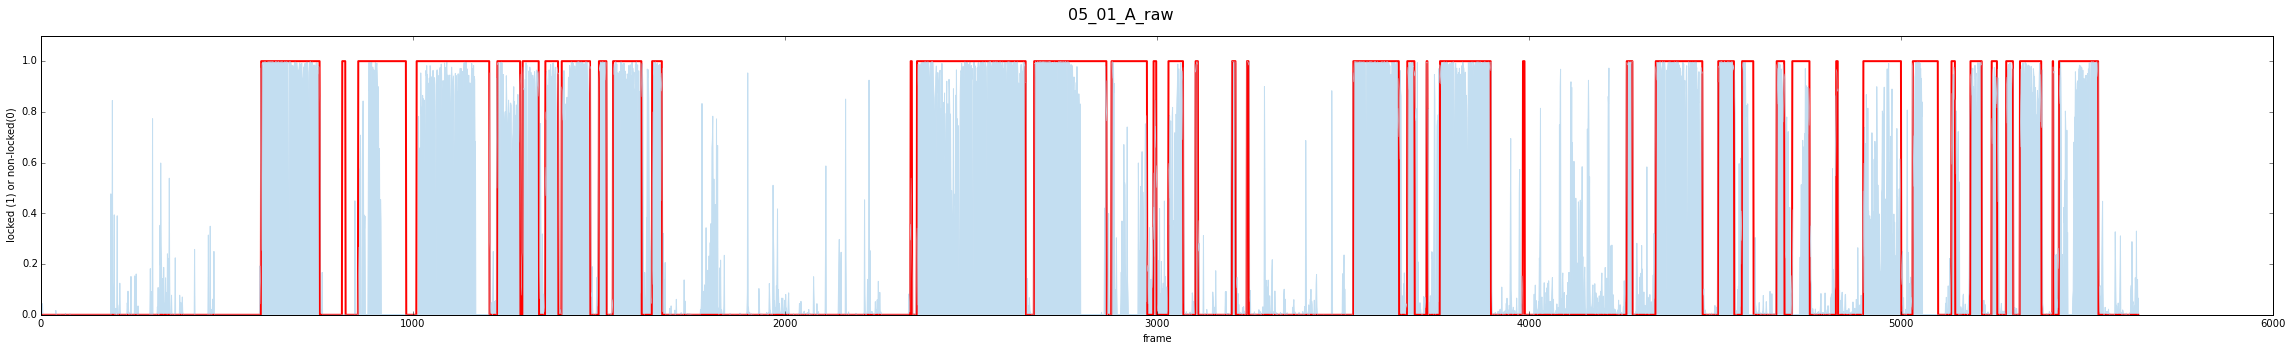

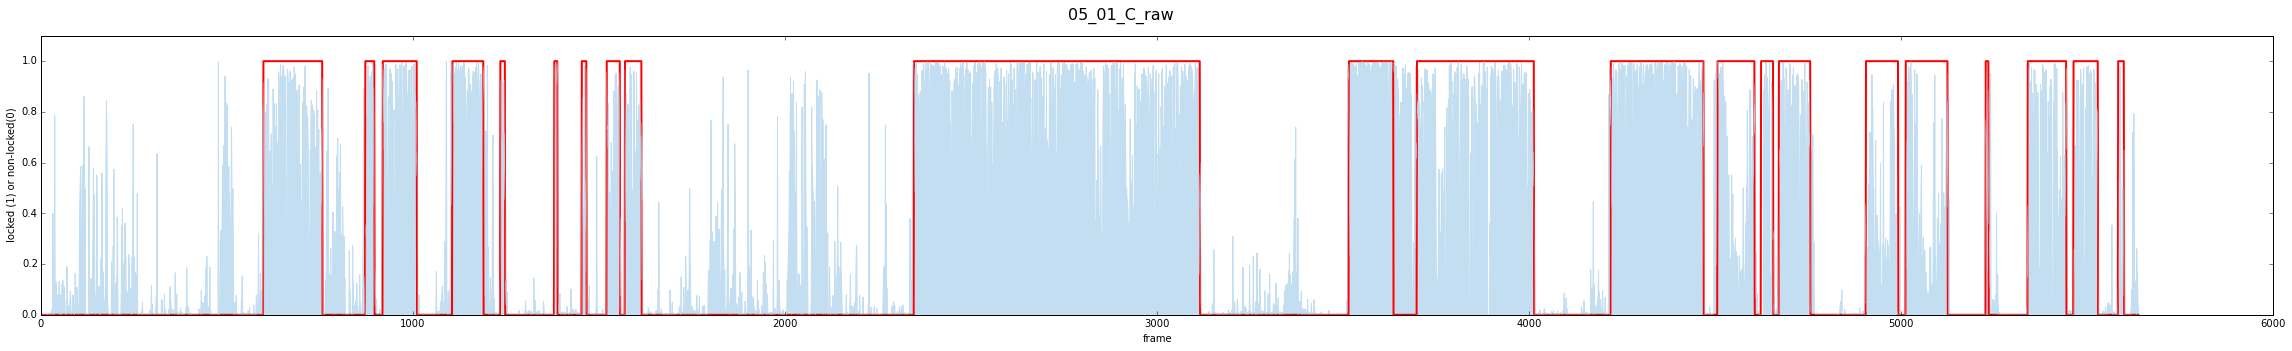

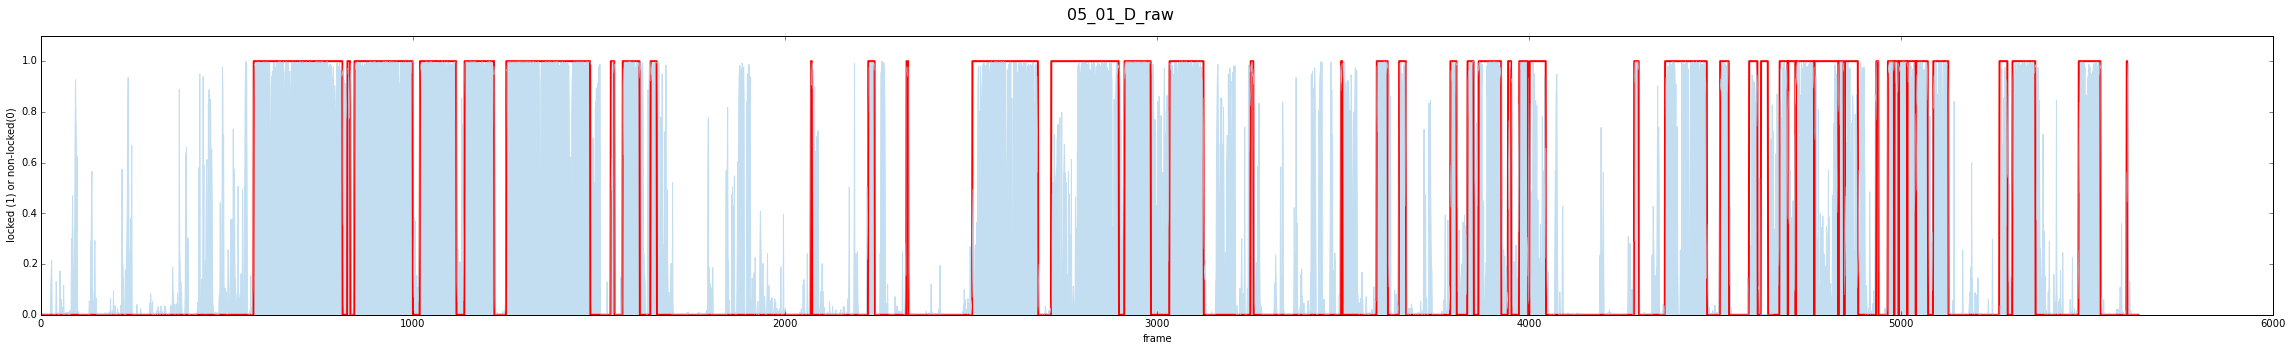

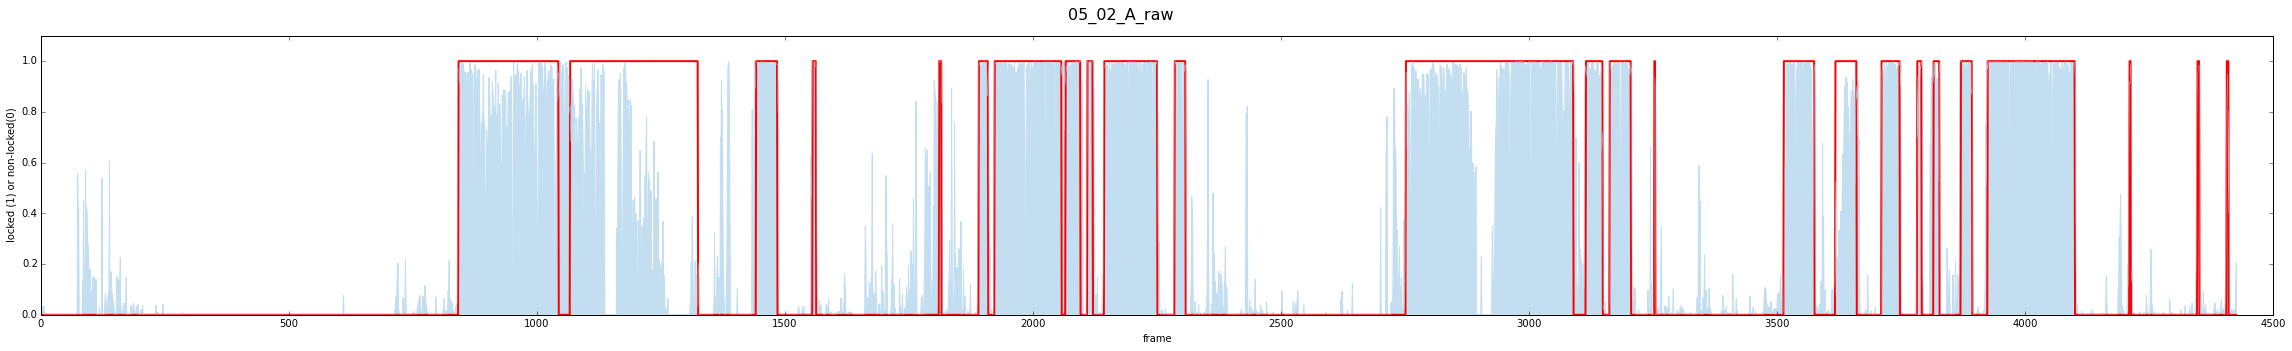

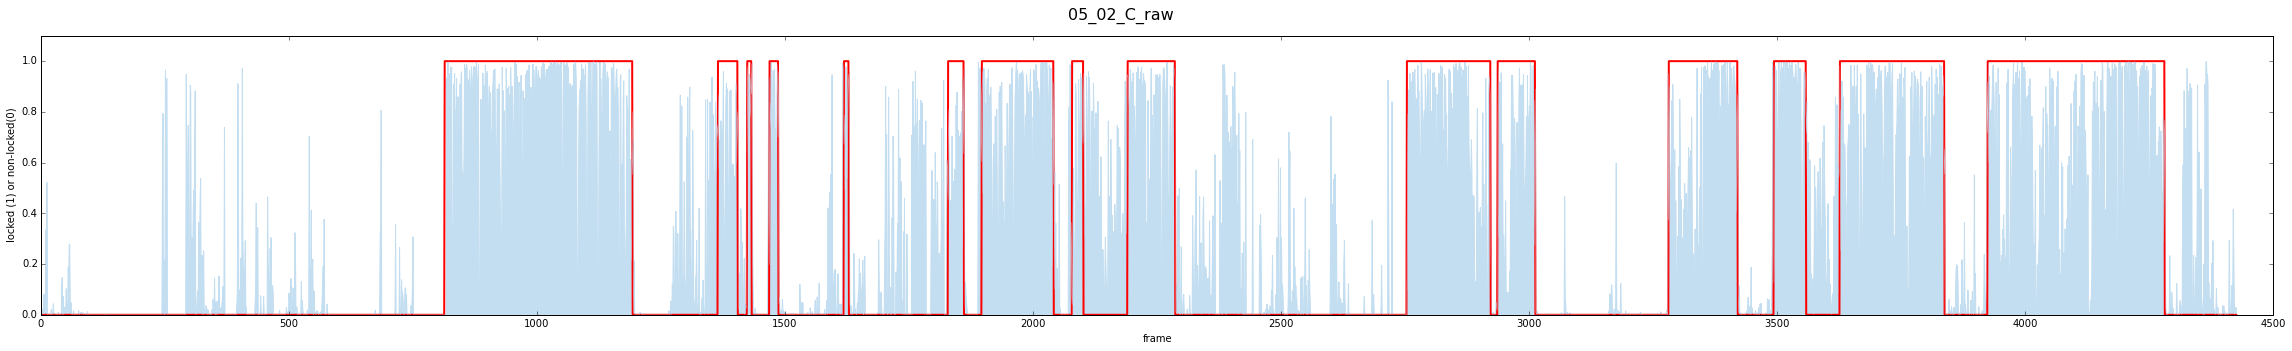

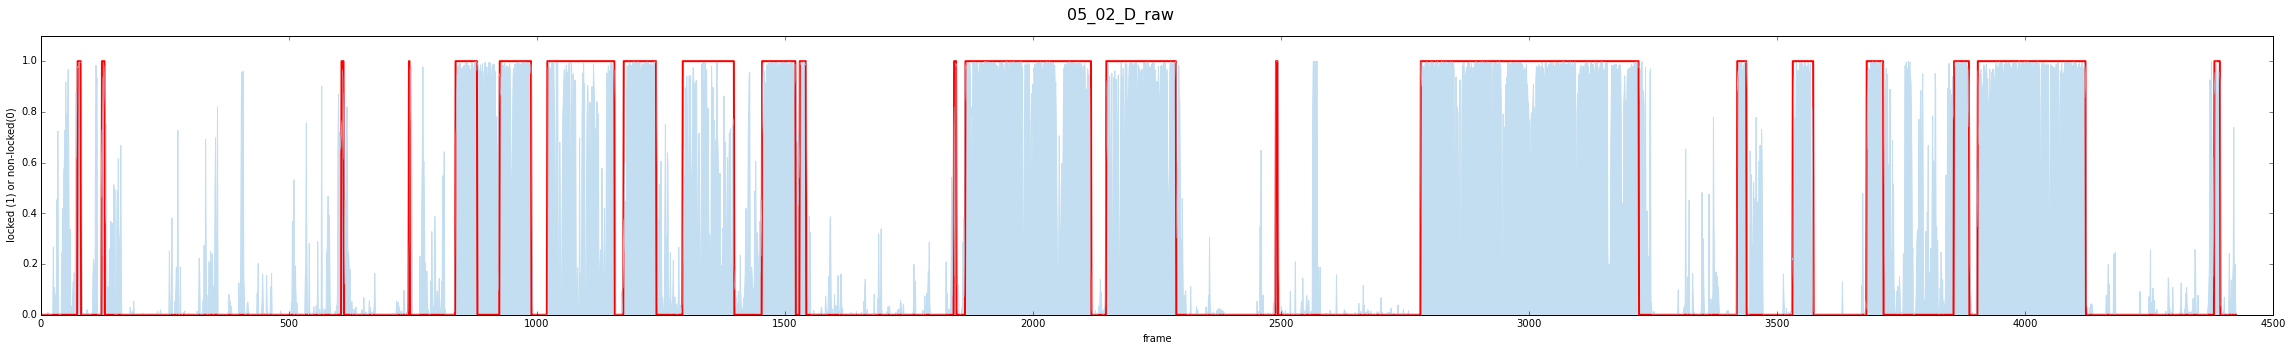

In [32]:
f1_scores = []
auc_scores = []
for movie_id, place in test_ids:
    frame_num = utils.frame_num(img_dir, movie_id)
    ts = utils.load_ts(movie_id, place, label_dir, frame_num)
    xs = utils.load_xs(movie_id, place, prediction_dir, frame_num, "score")
    predictions = [float(x) for x in xs]
    predictions_r = smoothing_methods.round_predictions(predictions, threshold=0.3)
    visualize(ts, predictions, frame_num, "%s_%s_%s" % (movie_id, place, "raw"))
    f1_scores.append(metrics.f1_score(ts, predictions_r))
    auc_scores.append(metrics.roc_auc_score(ts, predictions))
    print("%s_%s -> %f" % (movie_id,  place, metrics.roc_auc_score(ts, predictions)))
print("f1_score: %f" % (sum(f1_scores) / len(f1_scores)))
print("auc_score: %f" % (sum(auc_scores) / len(auc_scores)))

In [5]:
# majority

Parsing unknown version of ELAN spec... This could result in errors...
Parsing unknown version of ELAN spec... This could result in errors...
Parsing unknown version of ELAN spec... This could result in errors...
Parsing unknown version of ELAN spec... This could result in errors...
Parsing unknown version of ELAN spec... This could result in errors...
Parsing unknown version of ELAN spec... This could result in errors...
0.0


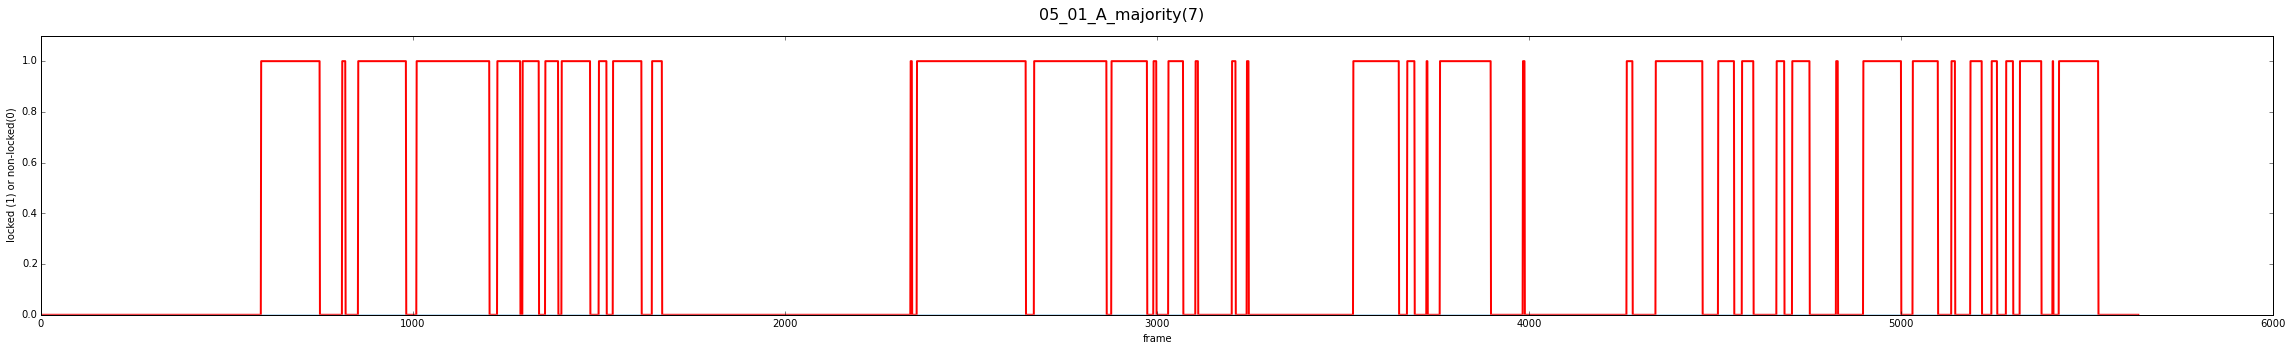

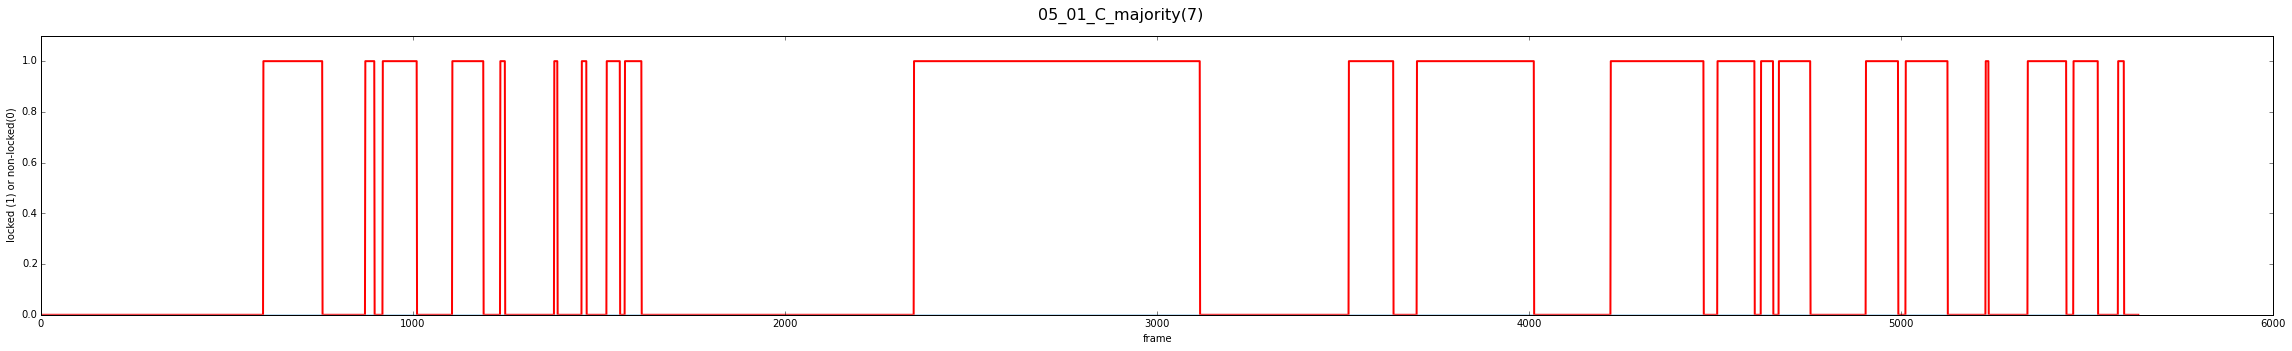

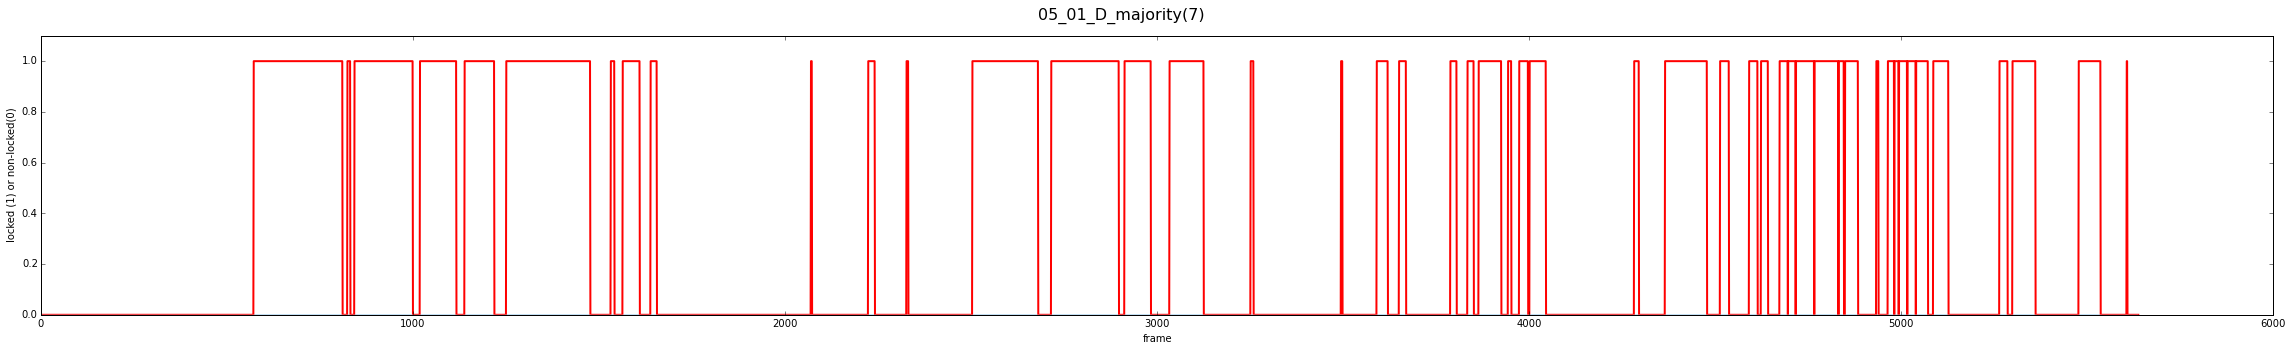

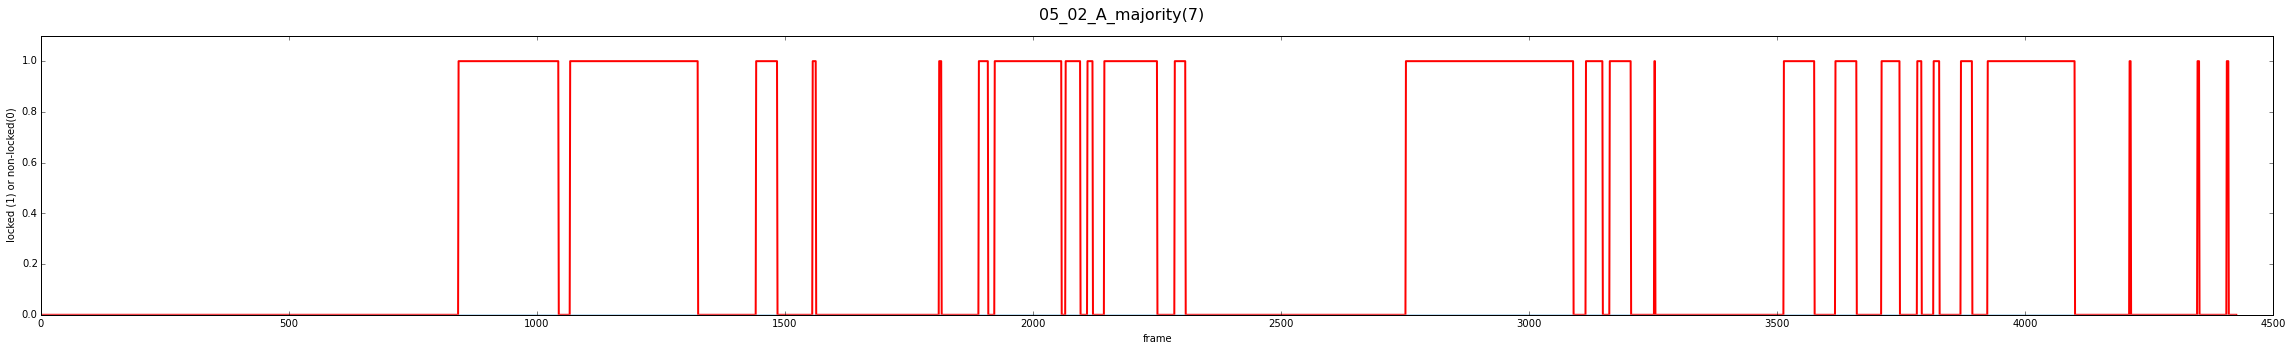

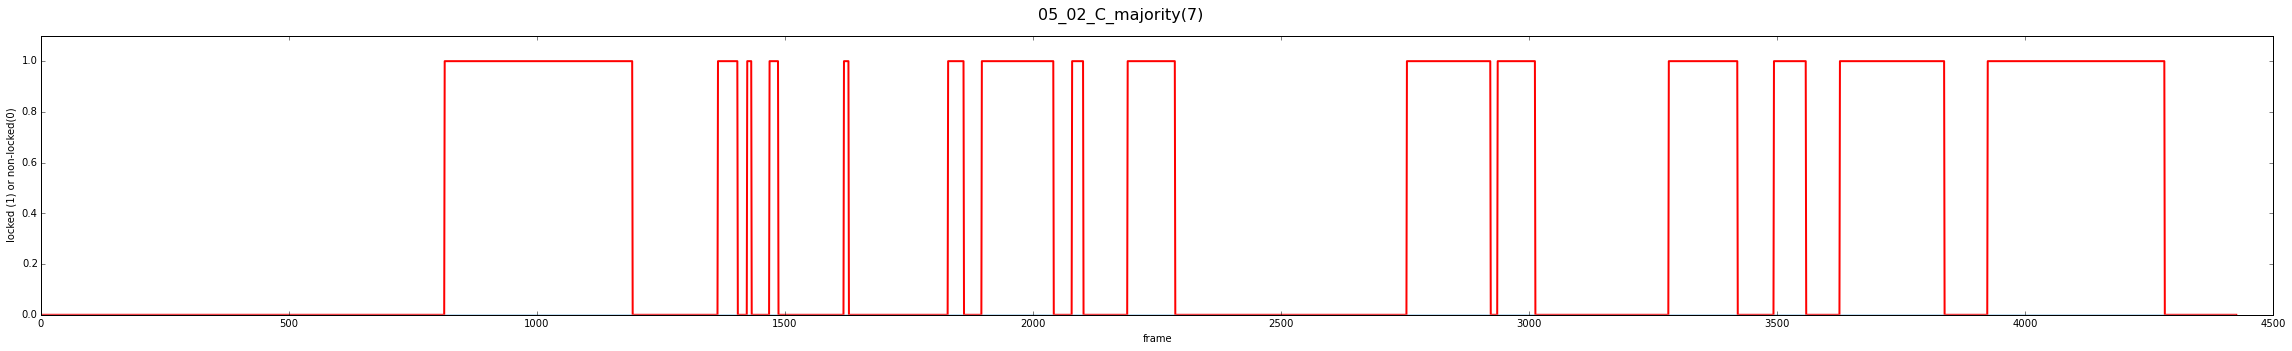

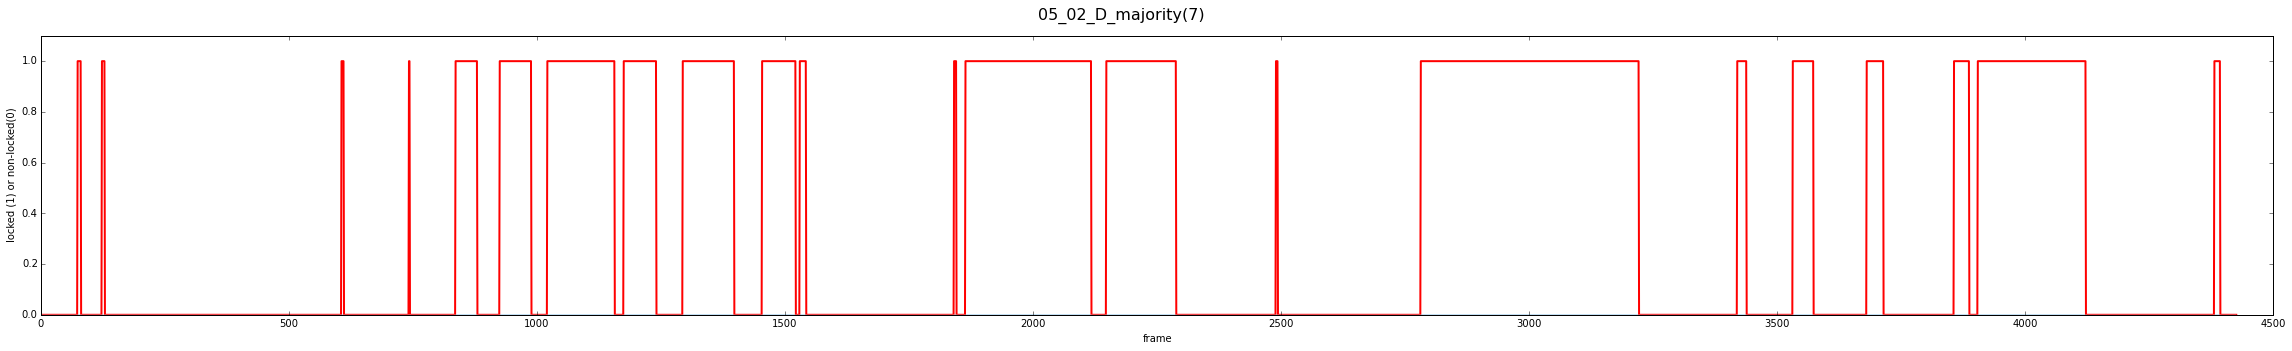

In [27]:
scores = []
for movie_id, place in test_ids:
    frame_num = utils.frame_num(img_dir, movie_id)
    ts = utils.load_ts(movie_id, place, label_dir, frame_num)
    xs =utils.load_xs(movie_id, place, prediction_dir, frame_num, "score")
    predictions = smoothing_methods.pre_smooth_by_majority(xs, window=3)
    visualize(ts, predictions, frame_num, "%s_%s_%s" % (movie_id, place, "majority(7)"))
    scores.append(metrics.f1_score(ts, predictions))
print(sum(scores)/len(scores))

In [36]:
f1_scores = []
auc_scores = []
for movie_id, place in test_ids:
    frame_num = utils.frame_num(img_dir, movie_id)
    ts = utils.load_ts(movie_id, place, label_dir, frame_num)
    xs = utils.load_xs(movie_id, place, prediction_dir, frame_num, "score")
    predictions = smoothing_methods.pre_average_predictions(xs, window=)
    predictions_r = smoothing_methods.round_predictions(predictions, threshold=0.3)
#     visualize(ts, predictions, frame_num, "%s_%s_%s" % (movie_id, place, "majority(7)"))
    f1_scores.append(metrics.f1_score(ts, predictions_r))
    auc_scores.append(metrics.roc_auc_score(ts, predictions))
    print("%s_%s -> %f" % (movie_id,  place, metrics.roc_auc_score(ts, predictions)))
print("f1_score: %f" % (sum(f1_scores) / len(f1_scores)))
print("auc_score: %f" % (sum(auc_scores) / len(auc_scores)))

Parsing unknown version of ELAN spec... This could result in errors...
05_01_A -> 0.880766
Parsing unknown version of ELAN spec... This could result in errors...
05_01_C -> 0.959390
Parsing unknown version of ELAN spec... This could result in errors...
05_01_D -> 0.933963
Parsing unknown version of ELAN spec... This could result in errors...
05_02_A -> 0.928261
Parsing unknown version of ELAN spec... This could result in errors...
05_02_C -> 0.961897
Parsing unknown version of ELAN spec... This could result in errors...
05_02_D -> 0.963432
f1_score: 0.856221
auc_score: 0.937951


In [8]:
# lstm output

05_01_A -> 0.922047
05_01_C -> 0.964032
05_01_D -> 0.944176
05_02_A -> 0.959187
05_02_C -> 0.948303
05_02_D -> 0.966428
f1_score: 0.869000
auc_score: 0.950696


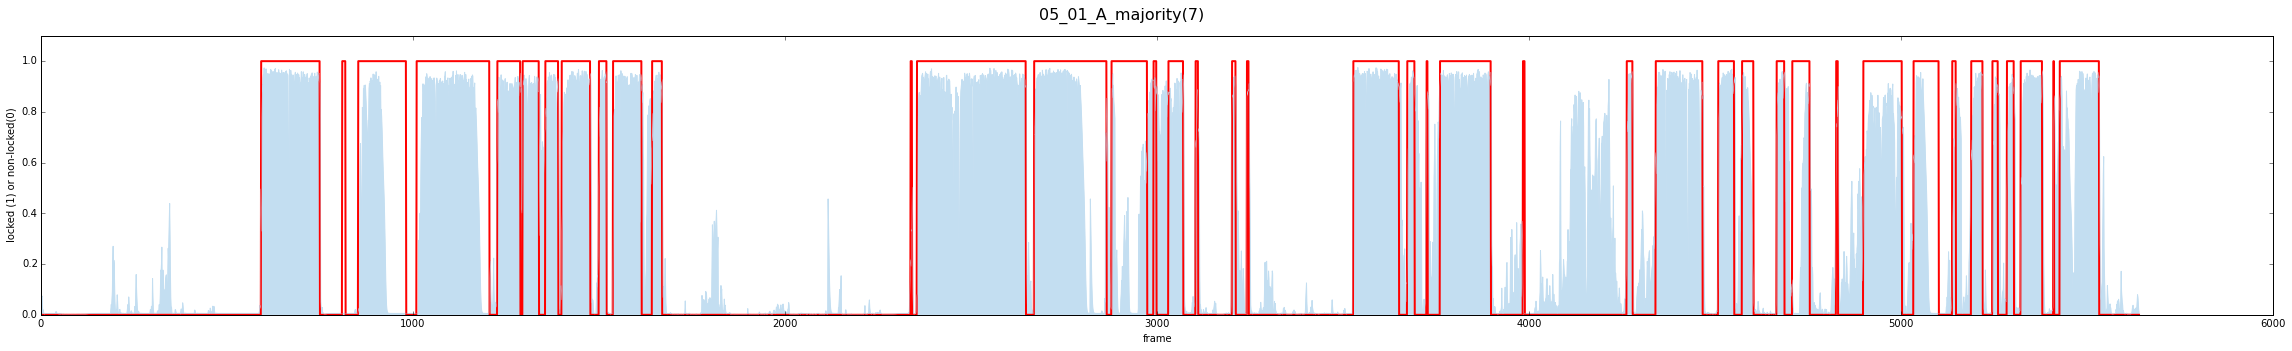

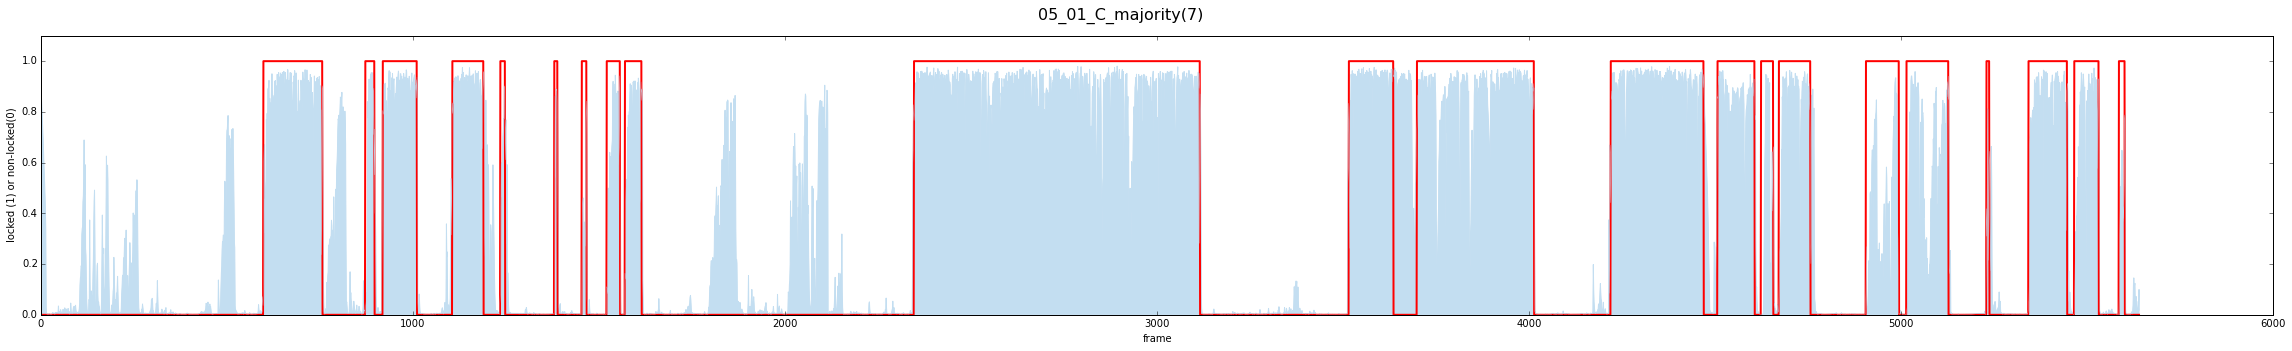

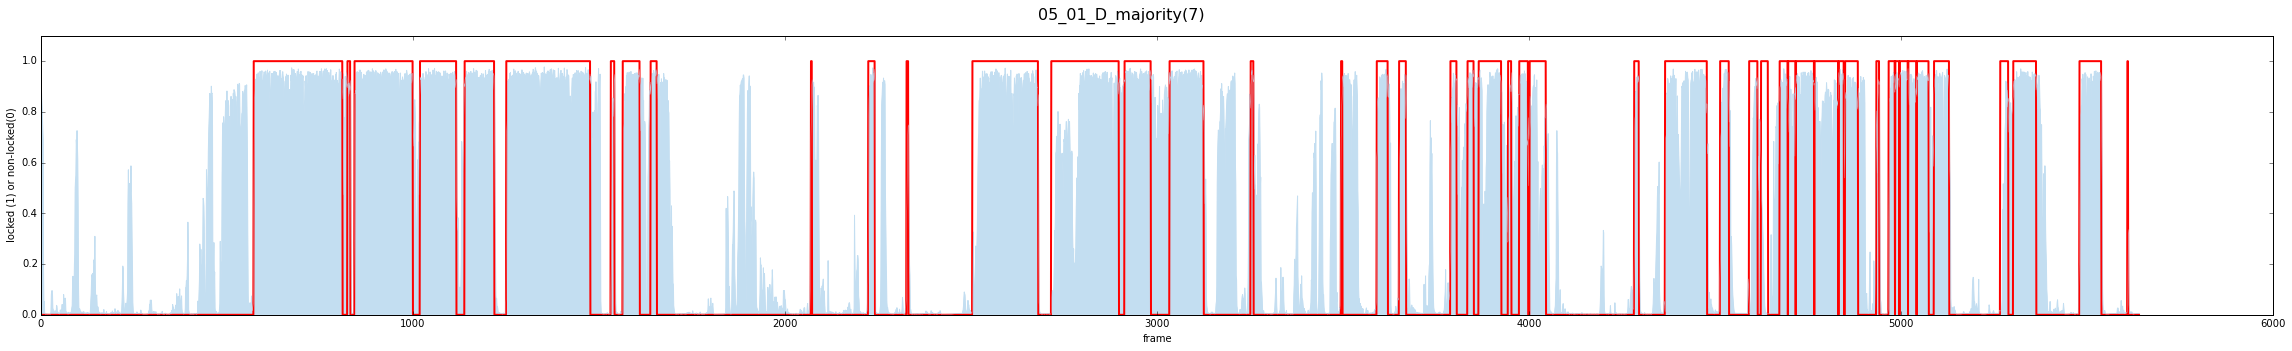

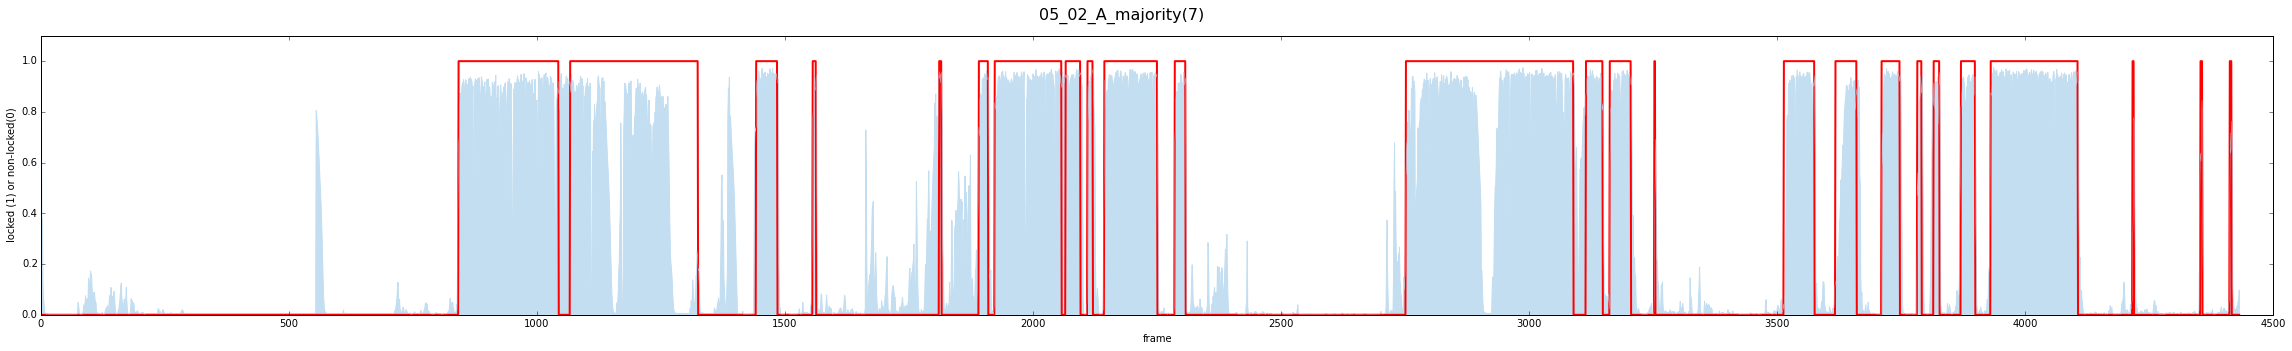

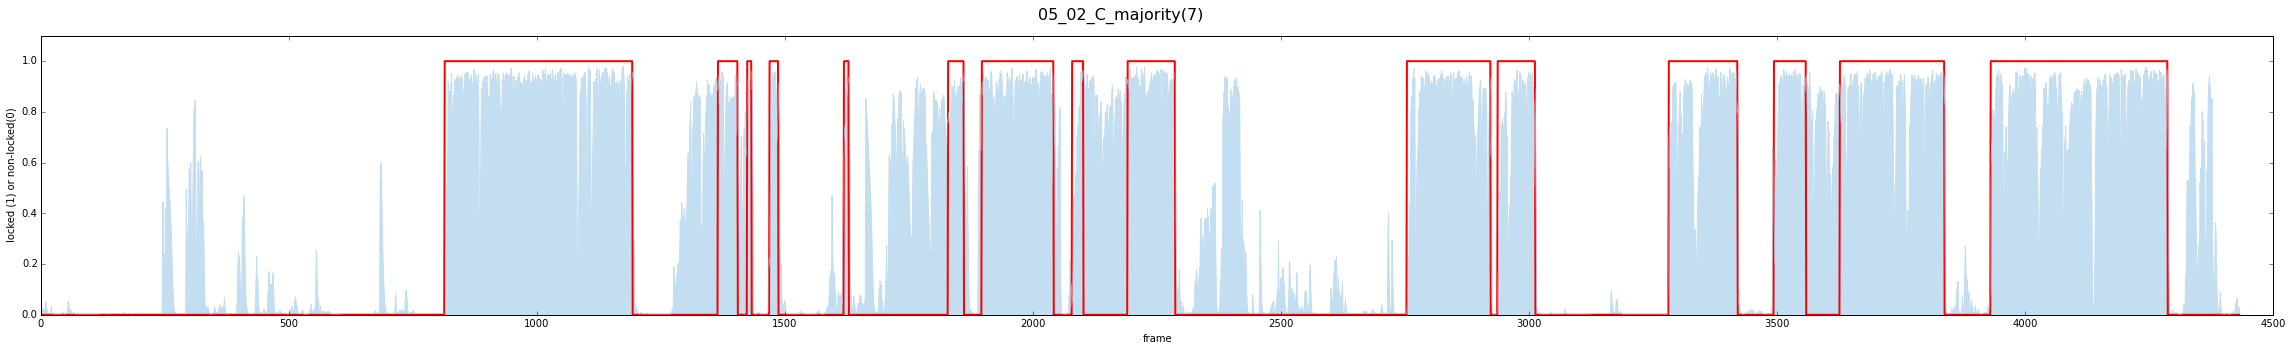

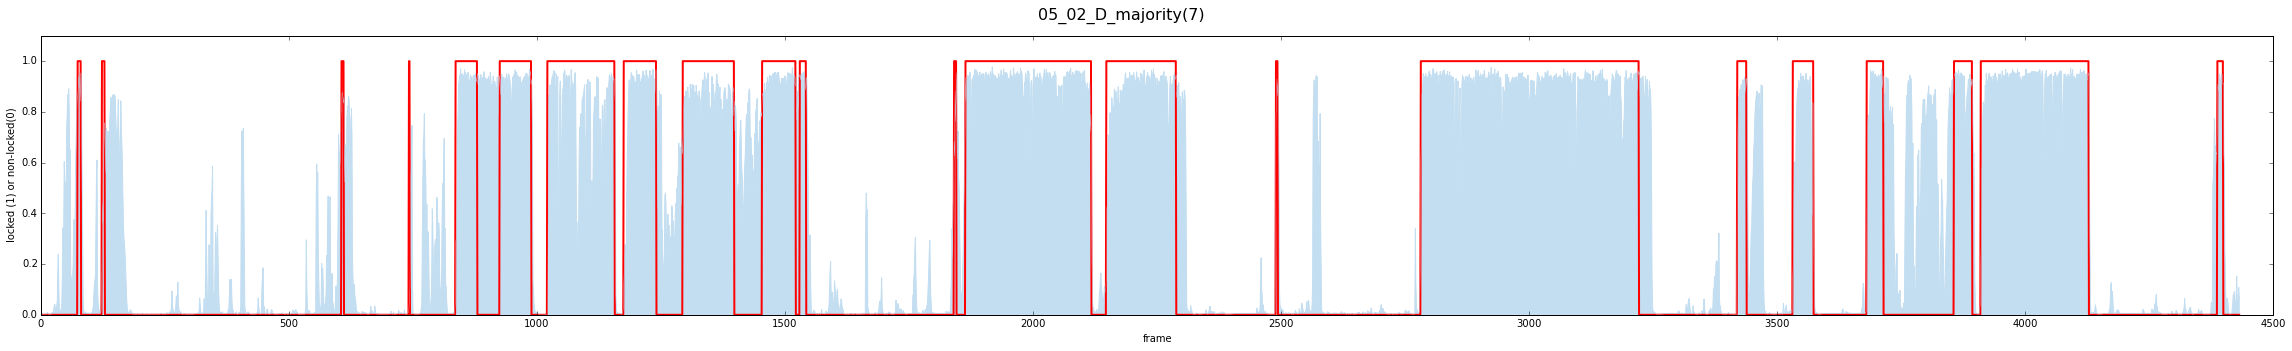

In [29]:
f1_scores = []
auc_scores = []
for movie_id, place in test_ids:
    path = os.path.join("./prediction", "%s_%s.pickle" % (movie_id, place))
    ts, ys = pickle.load(open(path, "r"))
    ys = [y[1] for y in ys]
    visualize(ts, ys, len(ts), "%s_%s_%s" % (movie_id, place, "majority(7)"))
    ys_r = smoothing_methods.round_predictions(ys, threshold=0.5)
    f1_scores.append(metrics.f1_score(ts, ys_r))
    auc_scores.append(metrics.roc_auc_score(ts, ys))
    print("%s_%s -> %f" % (movie_id,  place, metrics.roc_auc_score(ts, ys)))
print("f1_score: %f" % (sum(f1_scores) / len(f1_scores)))
print("auc_score: %f" % (sum(auc_scores) / len(auc_scores)))